# Librerias

In [0]:
%tensorflow_version 2.x

import math
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import seaborn as sn

# IPC Dataset

Lectura del dataset

In [0]:
df_ipc = pd.read_csv('data/ipc1719.csv')

Se obtienes una descripcion general de los datos

In [0]:
df_ipc.describe(include='all')

,fecha,valor
count,37,3.700000e+01
unique,37,NaN
top,2017-07,NaN
freq,1,NaN
mean,NaN,5.166147e+08
std,NaN,1.166730e+09
min,NaN,1.186000e+02
25%,NaN,9.258000e+02
50%,NaN,2.888967e+05
75%,NaN,3.491472e+08


Se observan los primeros 5 valores de los datos para obtener una vista preliminar

In [0]:
df_ipc.head()

,fecha,valor
0,2017-01,118.6
1,2017-02,142.4
2,2017-03,165.5
3,2017-04,192.8
4,2017-05,227.9


Se observa la densidad del valor del IPC desde el periodo del 2017 hasta enero del 2020

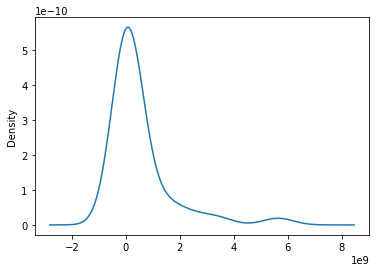

In [0]:
df_ipc.valor.plot.density()

Se convierte la columna fecha como indice del dataframe

In [0]:
df_ipc.index = pd.DatetimeIndex(df_ipc["fecha"])
df_ipc.drop('fecha',axis=1,inplace=True)
df_ipc.head()

,valor
fecha,
2017-01-01,118.6
2017-02-01,142.4
2017-03-01,165.5
2017-04-01,192.8
2017-05-01,227.9


Dado que las variaciones del IPC son altas, se tomaran en cuenta solo los valores a partir del 2018-01-01

In [0]:
df_ipc = df_ipc[df_ipc.index >= '2018-01-01']
df_ipc

,valor
fecha,
2018-01-01,4.943500e+03
2018-02-01,8.898200e+03
2018-03-01,1.486000e+04
2018-04-01,2.676290e+04
2018-05-01,5.622880e+04
2018-06-01,1.283985e+05
2018-07-01,2.888967e+05
2018-08-01,9.334252e+05
2018-09-01,3.111106e+06


Parametros de la RNN

In [0]:
SEQ_LEN = 6  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 5  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "valor"

Se grafican los datos

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7efdaee06a58>],
      dtype=object)

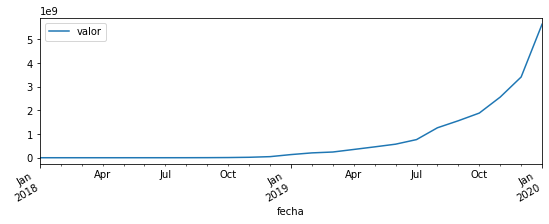

In [0]:
df_ipc.plot(subplots=True, figsize=(9, 3))

Se normaliza los resultados

In [0]:
# Normalize
scaler = MinMaxScaler()
values = df_ipc[RATIO_TO_PREDICT].to_numpy().reshape(-1, 1)
scaler.fit(values)
df_ipc[RATIO_TO_PREDICT] = scaler.transform(values)
df_ipc.head()

,valor
fecha,
2018-01-01,0.000000e+00
2018-02-01,7.017337e-07
2018-03-01,1.759613e-06
2018-04-01,3.871699e-06
2018-05-01,9.100216e-06


In [0]:
data = np.array(df_ipc[RATIO_TO_PREDICT]).reshape(-1, 1)

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i:i+target_size].reshape(-1))
  return np.array(data), np.array(labels)

In [0]:
TRAIN_SPLIT = math.floor(data.shape[0]*0.50) # 70% for training set

In [0]:
data_x_train, data_y_train = univariate_data(data, 0, TRAIN_SPLIT, SEQ_LEN, FUTURE_PERIOD_PREDICT)
data_x_test, data_y_test = univariate_data(data, TRAIN_SPLIT, None, SEQ_LEN, FUTURE_PERIOD_PREDICT)
data_x_train.shape

(6, 6, 1)

In [0]:
data_y_train.shape

(6, 5)

In [0]:
data_x_test.shape

(2, 6, 1)

In [0]:
data_y_test.shape

(2, 5)

# Definicion del Modelo

In [0]:
# TensorBoard
import datetime, os
%load_ext tensorboard

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9988), started 2:01:28 ago. (Use '!kill 9988' to kill it.)

<IPython.core.display.Javascript object>

In [0]:
input_layer = tf.keras.Input(shape=data_x_train.shape[-2:], name="input")
lstm_2 = tf.keras.layers.LSTM(256, activation='relu')(input_layer)
out = tf.keras.layers.Dense(FUTURE_PERIOD_PREDICT)(lstm_2)

model = tf.keras.models.Model(inputs=[input_layer], outputs=out)

model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0, learning_rate=0.001), loss='mean_squared_logarithmic_error')

model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 6, 1)]            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 265,477
Trainable params: 265,477
Non-trainable params: 0
_________________________________________________________________


In [0]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=100, 
    restore_best_weights=True)

model.fit(data_x_train, data_y_train,
          epochs=800,
          validation_data=(data_x_test, data_y_test),
          callbacks=[tensorboard_callback, es])

Train on 6 samples, validate on 2 samples
Epoch 1/800
6/6 [==============================] - 1s 171ms/sample - loss: 4.4974e-04 - val_loss: 0.0859
Epoch 2/800
6/6 [==============================] - 0s 8ms/sample - loss: 4.2542e-04 - val_loss: 0.0856
Epoch 3/800
6/6 [==============================] - 0s 5ms/sample - loss: 4.1810e-04 - val_loss: 0.0822
Epoch 4/800
6/6 [==============================] - 0s 5ms/sample - loss: 1.9323e-04 - val_loss: 0.0799
Epoch 5/800
6/6 [==============================] - 0s 5ms/sample - loss: 1.7661e-04 - val_loss: 0.0803
Epoch 6/800
6/6 [==============================] - 0s 5ms/sample - loss: 1.7680e-04 - val_loss: 0.0797
Epoch 7/800
6/6 [==============================] - 0s 5ms/sample - loss: 1.7754e-04 - val_loss: 0.0804
Epoch 8/800
6/6 [==============================] - 0s 6ms/sample - loss: 1.7984e-04 - val_loss: 0.0789
Epoch 9/800
6/6 [==============================] - 0s 5ms/sample - loss: 1.8218e-04 - val_loss: 0.0806
Epoch 10/800
6/6 [===========

# Visualizar Resultados

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:]), label='History')
  plt.plot(np.arange(num_out)/1, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/1, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

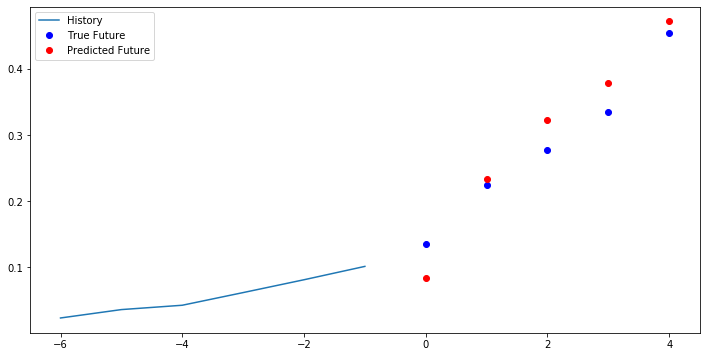

In [0]:
multi_step_plot(data_x_test[0], data_y_test[0], model.predict(data_x_test)[0])

## Predicted Data

In [0]:
data_test, data_test_y = univariate_data(data, 18, data.shape[0], SEQ_LEN, FUTURE_PERIOD_PREDICT)
data_test.shape, data_test_y.shape

((1, 6, 1), (1, 1))

In [0]:
prediction = model.predict(data_test)[0]

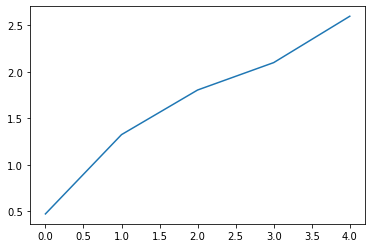

In [0]:
plt.plot(prediction)

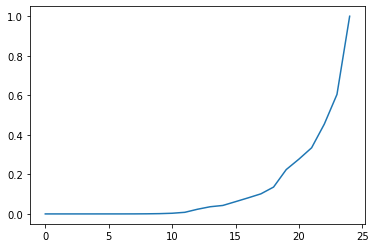

In [0]:
plt.plot(data)

In [0]:
real_data_prediction = scaler.inverse_transform(prediction.reshape(-1,1))

Valores reales de la prediccion

In [0]:
real_data_prediction

array([[2.6480253e+09],
       [7.4618716e+09],
       [1.0171241e+10],
       [1.1835445e+10],
       [1.4650405e+10]], dtype=float32)

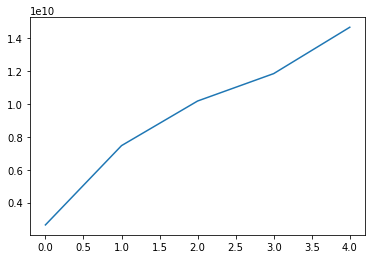

In [0]:
plt.plot(real_data_prediction)